## 09-Age Gridding

An adaptation of [agegrid-01](https://github.com/siwill22/agegrid-0.1) written by Simon Williams, Nicky Wright and John Cannon into an object-oriented format for use in GPlately.

In [1]:
import gplately

import numpy as np
import pygplates
import glob, os
import matplotlib.pyplot as plt
import matplotlib.axes as axs
import cartopy.crs as ccrs

gdownload = gplately.download.DataServer("Muller2019")
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

time = 0
continents = "./NotebookFiles/Global_EarthByte_GeeK07_COB_Terranes_2019_v2.gpml"
gplot = gplately.plot.PlotTopologies(model, time, continent_filename=continents)

Checking whether the requested files need to be updated...
Requested files are up-to-date!


### The SeafloorGrid object
Call the SeafloorGrid object - change the `save_directory` to the desired save directory.

In [2]:
seafloorgrid = gplately.oceans.SeafloorGrid(
    model, 
    gplot, 
    max_time = 410.,
    min_time = 400.,
    ridge_time_step=1.,
    ridge_sampling=0.5,
    resX = 2000, # resolution of regular grid to interpolate seafloor points onto
    resY = 1000,
    save_directory="./NotebookFiles/Notebook9", # continent masks, initial ocean seed points, and gridding input files are kept here
    file_collection = gdownload.file_collection, # A string to help name files according to a plate model "Muller2019"
    refinement_levels=6, # For the initial ocean points - a Stripy icosahedral grid
    initial_ocean_mean_spreading_rate = 50. # To use for the simplistic proximity to MOR spreading rate code
)

### Producing gridding input files
`seafloorgrid.reconstruct_by_topologies` prepares all data and ocean basin points needed for gridding and stores them in a *gridding input file* per timestep. 

It creates the initial ocean seed point icosahedral mesh, then recursively produces:
* Continent netCDF masks
* Points along ridges according to the specified `ridge_sampling` resolution

from `max_time` to `min_time`. Once that is complete, the `ReconstructByTopologies` object (written by Simon Williams, Nicky Wright, and John Cannon) from GPlately's `reconstruct` will be called.

`ReconstructByTopologies` (RBT) identifies active points on the ocean basin per timestep. It works as follows:

If an ocean point on one plate ID transitions into another rigid plate ID at the next timestep, RBT calculates the point's velocity difference between both plates. The point **may** have subducted/collided with a continent at this boundary if this velocity difference is higher than a set velocity threshold. To ascertain whether the point should indeed be deactivated, a second test is conducted: RBT checks the previous time position of the point and calculates this point’s proximity to the boundary of the plate ID polygon it is approaching. If this distance is higher than a set distance threshold, then the point is far enough away from the boundary that it cannot be subducted or consumed by it and hence the point is still active. Else, it is deactivated/deleted.

Once all active points and their data are identified, they are passed to the gridding input file for that timestep.
### 

NOTE: it is critical that this following line of code runs uninterrupted from `max_time` to `min_time` because plate and ocean point reconstructions are done using recursive stage rotations. *(`time` is initialised below to measure the time taken to execute the code)*

In [3]:
import time
start = time.time()
seafloorgrid.reconstruct_by_topologies()
end = time.time()
print(end - start)

Preparing all initial files...
Generating global point mesh...
Partitioning global mesh by COB terrane plate polygons...
Determining initial ocean basin point ages as of 410.0 Ma...
Finished building initial_ocean_seed_points!
Finished building MOR seedpoints at 410.0 Ma!
Finished building a continental mask at 410.0 Ma!
Finished building MOR seedpoints at 409.0 Ma!
Finished building a continental mask at 409.0 Ma!
Finished building MOR seedpoints at 408.0 Ma!
Finished building a continental mask at 408.0 Ma!
Finished building MOR seedpoints at 407.0 Ma!
Finished building a continental mask at 407.0 Ma!
Finished building MOR seedpoints at 406.0 Ma!
Finished building a continental mask at 406.0 Ma!
Finished building MOR seedpoints at 405.0 Ma!
Finished building a continental mask at 405.0 Ma!
Finished building MOR seedpoints at 404.0 Ma!
Finished building a continental mask at 404.0 Ma!
Finished building MOR seedpoints at 403.0 Ma!
Finished building a continental mask at 403.0 Ma!
Finis

### netCDF gridding
Calling `seafloorgrid.lat_lon_z_to_netCDF` grids the latitudes, longitudes and (for now) one set of z-data from each timestep's gridding input file (produced in `seafloorgrid.reconstruct_by_topologies()`) into netCDF format.

The desired z-data to grid is identified using a `gridding_data_index`. For now, seafloor age grids can be produced using `2`, spreading rate grids are `3`, and point IDs/indices through time are `5`. 

In [4]:
seafloorgrid.lat_lon_z_to_netCDF(gridding_data_index=2)

netCDF grid for 410.0 Ma complete!
netCDF grid for 409.0 Ma complete!
netCDF grid for 408.0 Ma complete!
netCDF grid for 407.0 Ma complete!
netCDF grid for 406.0 Ma complete!
netCDF grid for 405.0 Ma complete!
netCDF grid for 404.0 Ma complete!
netCDF grid for 403.0 Ma complete!
netCDF grid for 402.0 Ma complete!
netCDF grid for 401.0 Ma complete!
netCDF grid for 400.0 Ma complete!


### Plotting a sample output

Read one netCDF grid using GPlately's `Raster` object from `grids`, and plot it using the `PlotTopologies` object.

In [6]:
time = 400.0 # Ma
grid_filename = "{}/{}_SEAFLOOR_AGE_grid_{}Ma.nc".format(seafloorgrid.save_directory, seafloorgrid.file_collection, time)
age_grid = gplately.grids.Raster(filename=grid_filename)

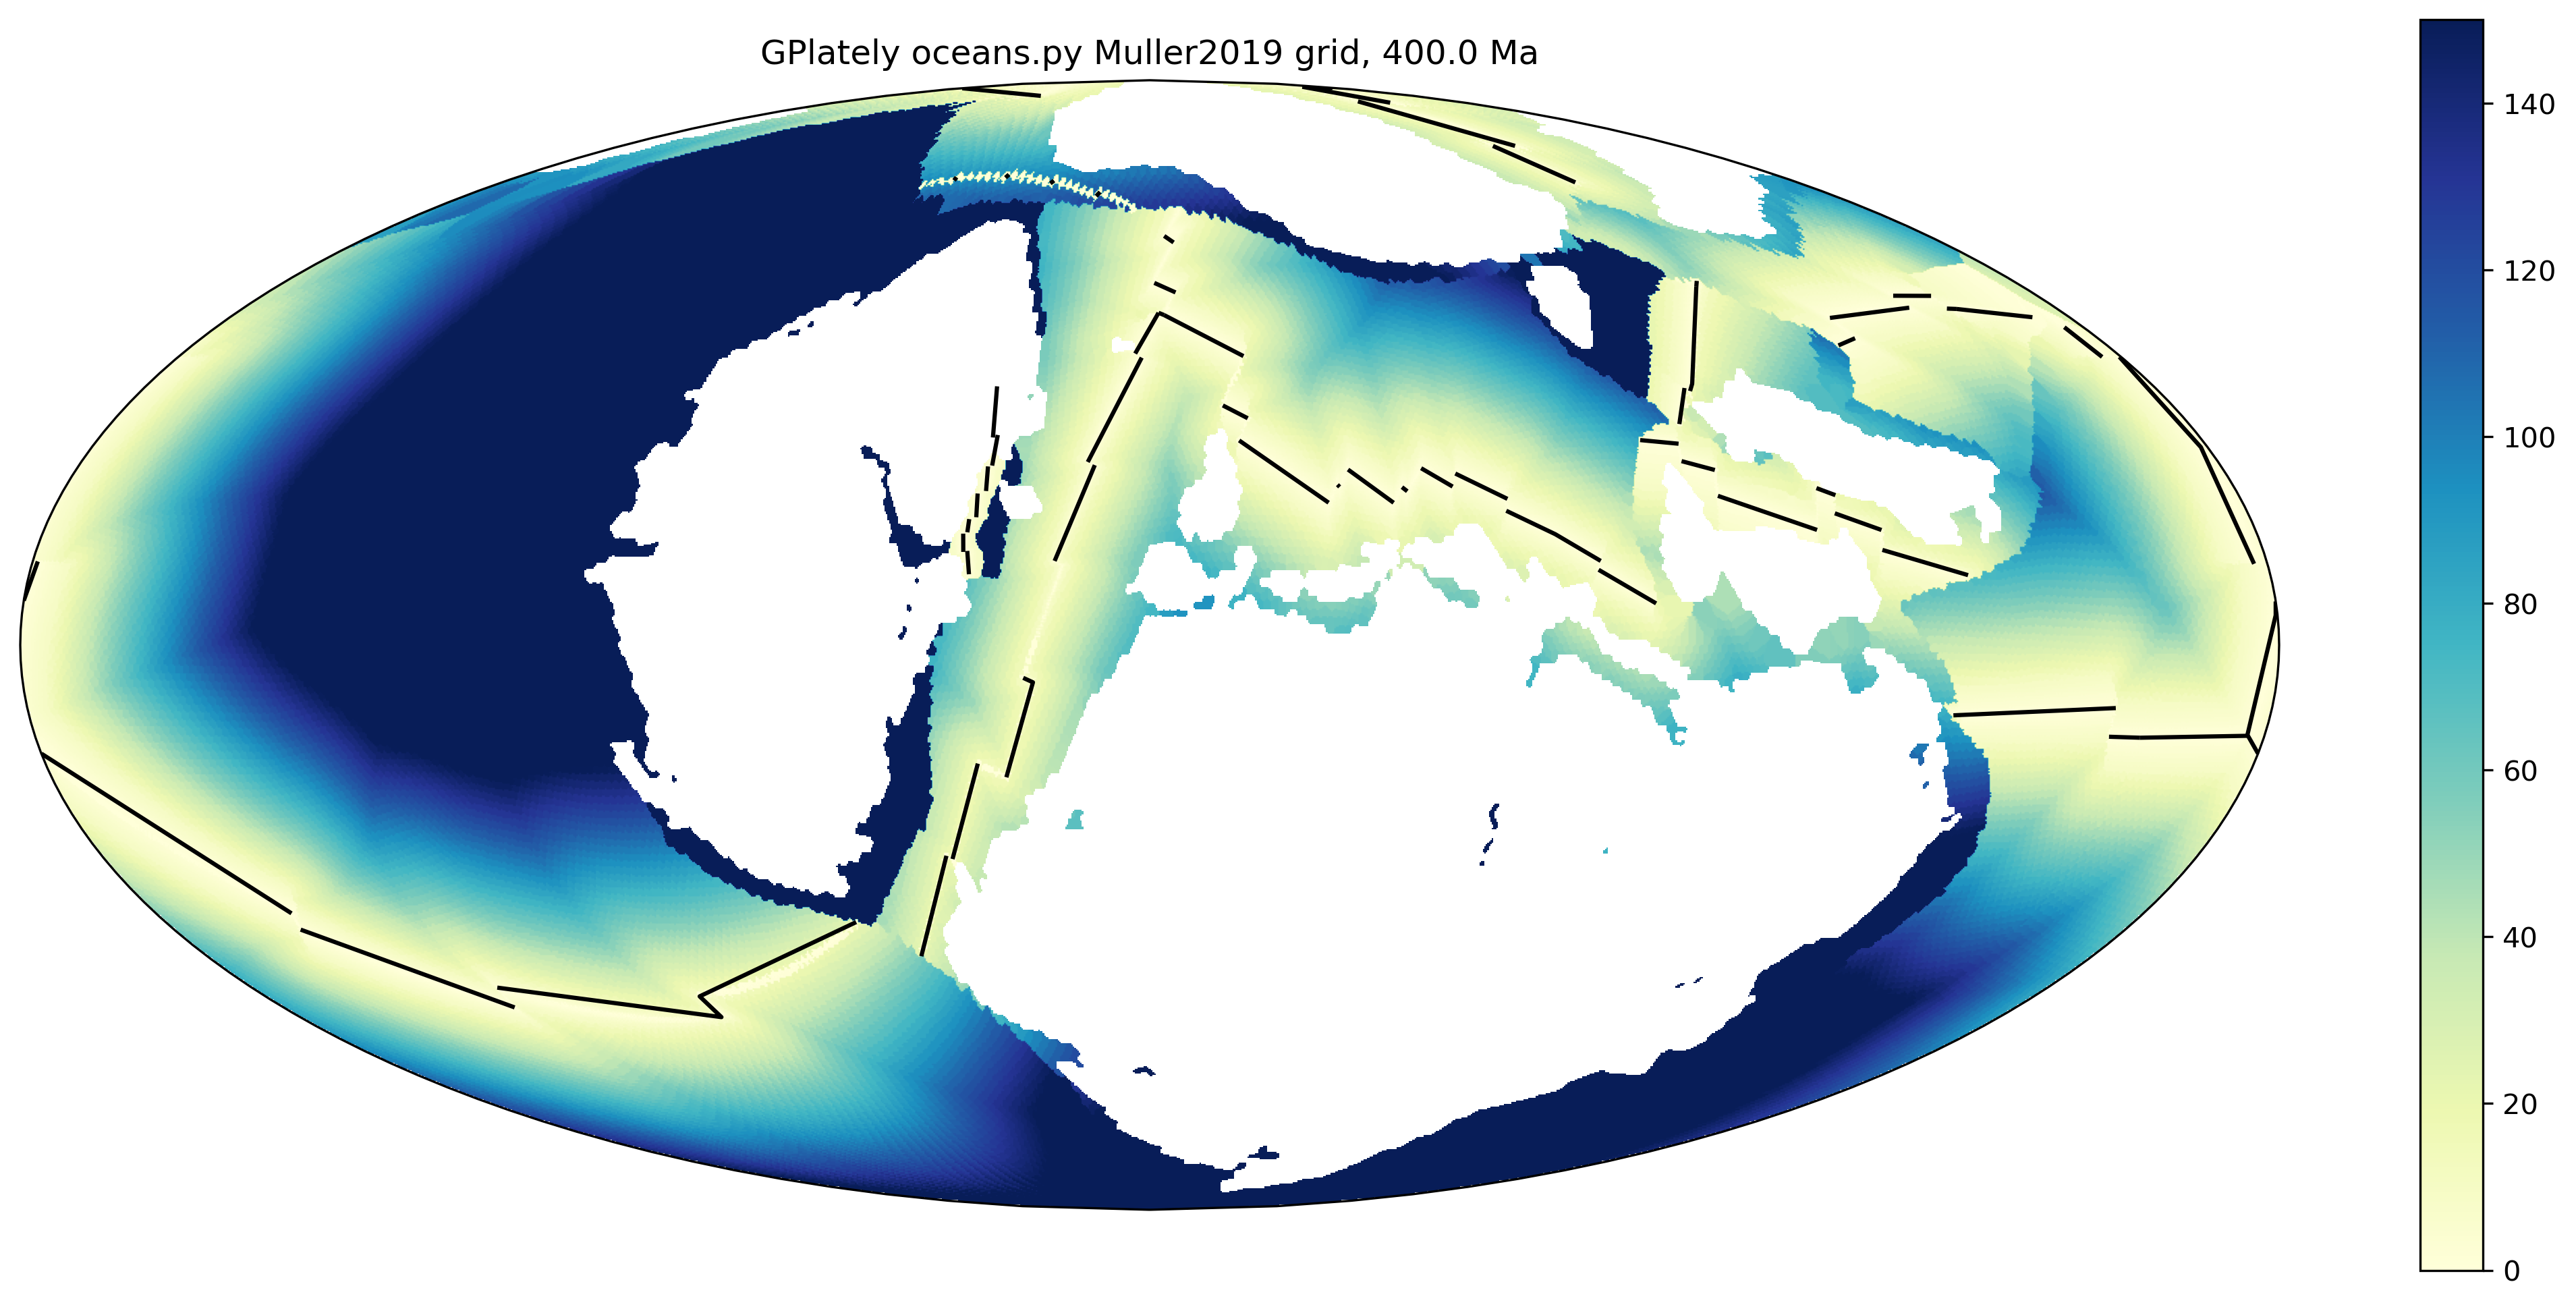

In [7]:
fig = plt.figure(figsize=(18,18), dpi=300, linewidth=2)
ax5 = fig.add_subplot(212, projection=ccrs.Mollweide(central_longitude=20))

gplot.time = time
plt.title("GPlately oceans.py {} grid, {} Ma".format(seafloorgrid.file_collection, time))
im2 = gplot.plot_grid(
    ax5, 
    age_grid.data, 
    cmap="YlGnBu",
    vmin = 0, 
    vmax =150,
)
gplot.plot_ridges(ax5)
plt.colorbar(im2)